In [1]:
import json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
import random
import numpy as np
import csv

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
merchant_id = '11167ECFF94860EA'

In [4]:
file = '/data/predict/'+merchant_id+'/'+merchant_id+'_logs.json'

In [5]:
users = {}
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if data['visitor_id'] not in users:
            users[data['visitor_id']] = []
        for prod_idx in data['viewed_products']:
            try:
                users[data['visitor_id']].append(prod_idx)
            except ValueError: 
                print('Sktrain_labelsiped ' + prod_idx)

59810it [00:00, 121673.27it/s]


In [6]:
users_lens = list(map(lambda x: len(x), users.values()))

In [7]:
print(len(users.keys()))

15710


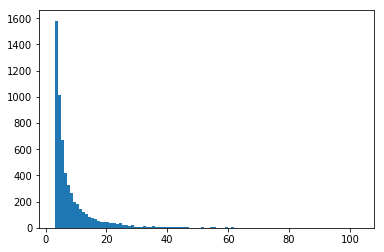

In [8]:
d = plt.hist(users_lens, bins=100, range=(3, 103))

In [9]:
products = {}
for u in users.values():
    for pid in u:
        products[pid] = 1
product_idxs = list(products.keys())
product_ids = {v: k for k, v in enumerate(product_idxs)}

number_of_classes = len(product_idxs)

In [10]:
print(number_of_classes)

2043


In [11]:
def dedup(seq):
    seen = set()
    seen_add = seen.add

    return [x for x in seq if not (x in seen or seen_add(x))]

In [12]:
class PairDataCollector:
    def __init__(self):
        self.data = [[],[]]
        self.labels = []
    
    def add(self,i,j):
        self.add_real_pair(i,j)
        self.add_fake_pair(i)
    
    def add_real_pair(self,i,j):
        self.data[0].append([i])
        self.data[1].append([j])
        self.labels.append([[1]])
        
    def add_fake_pair(self,i):
        self.data[0].append([i])
        self.data[1].append([random.randint(0,number_of_classes)])
        self.labels.append([[0]])
        
    def get(self):
        return (
            [np.array(self.data[0]), np.array(self.data[1])], 
            np.array(self.labels)
        )
        
    
train_data_collector = PairDataCollector()
valid_data_collector = PairDataCollector()


for uid,products in tqdm(users.items()):
    ids = dedup(list(map(lambda x: product_ids[x], products)))
    collector = valid_data_collector if random.random() < 0.1 else train_data_collector
    for i in ids:
        for j in ids:
            collector.add(i,j)
            
product_pair_data, product_pair_labels = train_data_collector.get()
val_product_pair_data, val_product_pair_labels = valid_data_collector.get()

100%|██████████| 15710/15710 [00:02<00:00, 6804.49it/s]


In [13]:
from keras.models import Model
from keras.layers import Input, Embedding, Activation
from keras.layers.merge import dot
from keras.optimizers import Nadam

factors = 100

input_l = Input(shape=(1,))
input_r = Input(shape=(1,))

emb_layer = Embedding(number_of_classes, factors)

emb_layer_left  = emb_layer(input_l)
emb_layer_right  = emb_layer(input_r)

merged = dot([emb_layer_left, emb_layer_right], 2)
activated = Activation('sigmoid')(merged)

cf_model = Model([input_l, input_r], activated)
cf_model.compile(Nadam(0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [14]:
cf_model.fit(
    product_pair_data, 
    product_pair_labels,
    batch_size=256, 
    validation_data = (val_product_pair_data, val_product_pair_labels),
    epochs=2
)

Train on 566328 samples, validate on 55978 samples
Epoch 1/2
566328/566328 [==============================] - 9s 15us/step - loss: 0.5537 - binary_accuracy: 0.7183 - val_loss: 0.5395 - val_binary_accuracy: 0.7187
Epoch 2/2
566328/566328 [==============================] - 6s 10us/step - loss: 0.4621 - binary_accuracy: 0.7837 - val_loss: 0.5355 - val_binary_accuracy: 0.7203


In [15]:
emb_weights = emb_layer.get_weights()

In [16]:
import bcolz
bcolz.carray(emb_weights, rootdir='/data/predict/'+merchant_id+'/'+merchant_id+'_embedding', mode='w')

carray((1, 2043, 100), float32)
  nbytes := 798.05 KB; cbytes := 1.52 MB; ratio: 0.51
  cparams := cparams(clevel=5, shuffle=1, cname='lz4', quantize=0)
  chunklen := 1; chunksize: 817200; blocksize: 32768
  rootdir := '/data/predict/11167ECFF94860EA/11167ECFF94860EA_embedding'
  mode    := 'w'
[[[ 0.21508138  0.06259327 -0.02700626 ..., -0.01126878  0.17612952
    0.1840426 ]
  [ 0.26316366 -0.12279879 -0.1504733  ...,  0.06608707 -0.06924476
   -0.20034002]
  [-0.4152433   0.0571893   0.07921264 ...,  0.00810577  0.07145333
    0.25571728]
  ..., 
  [-0.21169321 -0.03184654  0.21299098 ..., -0.22878352 -0.23803233
    0.08618272]
  [ 0.14402542 -0.0603481  -0.15263127 ...,  0.15807715  0.26720899
   -0.0248779 ]
  [-0.17136791 -0.02372516  0.25303972 ...,  0.02841763 -0.01128649
    0.03050606]]]

## Eye ball validation

In [17]:
product_map = {}
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_catalog.csv', 'r', encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile)
    header = next(spamreader)
    item_id = header.index('item')
    image_url = header.index('image')
    title = header.index('title')
    link = header.index('link')
    
    for row in spamreader:
        if row[item_id] in product_ids:
            product_map[product_ids[row[item_id]]] = {
                'idx': product_ids[row[item_id]],
                'id':row[item_id],
                'image':row[image_url], 
                'title':row[title], 
                'link':row[link]
            }

In [18]:
result = cf_model.predict([np.array([0]*number_of_classes), np.array(range(number_of_classes))])

In [19]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 



In [20]:
product_template = "<td style='width:130px'><img src='%(image)s' style='width:130px'/><a href='%(link)s'>%(id)s (%(idx)s)</a><br/>%(title)s</td>"
missing_product_template = "<td style='width:130px'><img src='http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png' style='width:130px'/>%(idx)s</td>"

#''

def get_related(idx):
    result = cf_model.predict([np.array([idx]*number_of_classes), np.array(range(number_of_classes))])
    return np.argsort(result.reshape(number_of_classes))[::-1]

def display_products(products, max_count=6):
    html = '<table><tr>'
        
    count = 0
    for p in products:
        if p in product_map:
            html += product_template  % product_map[p]
            count += 1
            if count > max_count:
                break
        
    html += '</tr></table>'
    
    core_display(HTML(html))

In [37]:
idx = -1
while idx not in product_map:
    idx = random.randint(0,number_of_classes)
    
print(idx)
related_products = get_related(idx)
display_products(related_products)
display_products(related_products[::-1])

369


2040032 (369)Jungen-Kapuzen-Pullover mit Skater-Waschbär,2040071 (1528)Jungen-Jeans mit elastischem Bund,"2040873 (86)Jungen-Unterhemd mit süßem Monster-Aufdruck, 2er Pack",2039992 (268)Jungen-Pullover mit Streifenmuster,2040088 (386)Jungen-Sweatshirt mit coolem Frontaufdruck,2040078 (258)Jungen-Shirt in 2-in-1-Optik,2039988 (601)Jungen-Pullover mit Zopfmuster


2040373 (1092)Damen-Steppjacke mit 2-Wege-Reißverschluss,2040960 (187)Damen-Parka mit Kunstfell,2040197 (1119)Damen-Anorak mit Druckknöpfen,2040376 (1427)Damen-Jacke mit Kunstfell-Kragen,2042459 (1760)Damen-Shirt mit Rollkragen,2040836 (945)Damen-Anorak mit aufgesetzten Taschen,"2045713 (556)KeDDii Scoop Katzenstreuschaufel, aus Die Höhle der Löwen"


In [22]:
related_products = get_related(1160)
display_products(related_products)
display_products(related_products[::-1])

"2041959 (1179)Herren-Gesundheitssocken aus reiner Baumwolle, 3er Pack","2040467 (801)Damen-Rioslip mit Streifenmuster, 3er Pack","2040537 (1019)Damen-Rioslip mit Spitze an den Seiten, 2er Pack","2040413 (1525)Damen-Minislip mit Punkte-Muster, 2er Pack","2042383 (781)Duschtuch in supersofter Qualität, 70x140cm",1535794 (1451)Damen-Unterhemd,"2040159 (1705)Damen-BH mit verzierten Cups, mit Bügel"


2042807 (1216)Damen-Sweatshirt mit Kordelzug und Trend-Muster,2043559 (136)Damen-2-in-1-Allwetterjacke,2041503 (1191)Damen-Pullover mit modischem Strickmuster,2040373 (1092)Damen-Steppjacke mit 2-Wege-Reißverschluss,"2042425 (260)Mitteldecke mit Glitzergarn, ca. 80x80cm",2040960 (187)Damen-Parka mit Kunstfell,2041507 (100)Damen-Pullover in gestrickter Melange-Optik


# Predict next visit in session

In [179]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [180]:
users_with_product_idxs = {}
for uid,products in users.items():
    ids = dedup(list(map(lambda x: product_ids[x], products)))[-40:]
    if len(ids) > 1:
        if len(ids) not in users_with_product_idxs:
            users_with_product_idxs[len(ids)] = []
        users_with_product_idxs[len(ids)].append(ids)
    
del users

In [181]:
max_batch_size = 32
test_size = 0.1
user_batches = []
user_valid_batches = []
for len_group in users_with_product_idxs.values():
    random.shuffle(len_group)
    for batch in chunks(len_group, max_batch_size):
        batch_data = np.array(list(map(lambda x: x[:-1], batch)))
        batch_labels = np.expand_dims(np.array(list(map(lambda x: x[1:], batch))), axis=2)
        if random.random() < test_size:
            user_valid_batches.append(
                (batch_data, batch_labels)
            )
        else:
            user_batches.append(
                (batch_data, batch_labels)
            )

In [182]:

def generate_from_array(arr):
    while True:
        random.shuffle(arr)
        for i in arr: 
            yield i
    

In [251]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout, TimeDistributed,Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam


n_hidden = factors

model=Sequential([
        Embedding(number_of_classes, n_hidden, batch_input_shape=(None,None), 
                  name='embedding', trainable=False, weights=emb_weights),
        #BatchNormalization(),
        GRU(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        #Dropout(0.2),
        #GRU(4*n_hidden,return_sequences=True),
        #Dropout(0.2),
        #TimeDistributed(Dense(n_hidden, activation='relu')),
        TimeDistributed(Dense(number_of_classes, activation='softmax'))
    ])

In [252]:
from keras.backend import reshape, prod, shape, stack
from keras.metrics import sparse_top_k_categorical_accuracy

def flatten_first_n_dimension(x, first_n=2):
    new_dims = stack([prod(shape(x)[:first_n]), prod(shape(x)[first_n:])])

    return reshape(x, new_dims)

def sparse_timedistributed_top_k_categorical_accuracy(y_true, y_pred, k=5):
    y_true_reshaped = flatten_first_n_dimension(y_true)
    y_pred_reshaped = flatten_first_n_dimension(y_pred)

    return sparse_top_k_categorical_accuracy(y_true_reshaped, y_pred_reshaped, k)

In [253]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy',sparse_timedistributed_top_k_categorical_accuracy], optimizer=Nadam())

In [254]:
import csv
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_variable_length_model_id_map.csv', 'w',encoding='utf8') as csvfile:
    spamwriter = csv.writer(csvfile)
    for line in product_idxs:
        spamwriter.writerow([line])

In [255]:
from keras.callbacks import ModelCheckpoint
filepath='/data/predict/'+merchant_id+'/'+merchant_id+'_variable_length_model-{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_sparse_timedistributed_top_k_categorical_accuracy', verbose=1, save_best_only=False, mode='max')

In [256]:
model.fit_generator(
    generate_from_array(user_batches), 
    validation_data=generate_from_array(user_valid_batches), 
    steps_per_epoch=len(user_batches),
    validation_steps=len(user_valid_batches),
    #callbacks=[checkpoint],
    epochs=2
)

Epoch 1/2
240/240 [==============================] - 4s 15ms/step - loss: 5.8678 - sparse_categorical_accuracy: 0.0658 - sparse_timedistributed_top_k_categorical_accuracy: 0.1927 - val_loss: 5.3789 - val_sparse_categorical_accuracy: 0.0911 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.2379
Epoch 2/2
240/240 [==============================] - 2s 10ms/step - loss: 5.1260 - sparse_categorical_accuracy: 0.0949 - sparse_timedistributed_top_k_categorical_accuracy: 0.2585 - val_loss: 5.2886 - val_sparse_categorical_accuracy: 0.1032 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.2627


## Eye ball validation

In [257]:
import csv

In [258]:
product_map = {}
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_catalog.csv', 'r', encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile)
    header = next(spamreader)
    item_id = header.index('item')
    image_url = header.index('image')
    title = header.index('title')
    link = header.index('link')
    
    for row in spamreader:
        product_map[row[item_id]] = [row[image_url], row[title], row[link]]

In [259]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [268]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def product_to_url(product):
    try:
        
        return [product] + product_map[list(product_idxs)[product]] + [list(product_idxs)[product]]
    except KeyError:
        return [product,'http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png','UNKNOWN','', '']

def display_session(session):
    products = list(map(product_to_url, session))
    predictions = model.predict([session])
    html = '<table>'
    seen = set()
    for i,product in enumerate(products):
        html += '<tr>'
        html += '<th style="text-align:center;width:120px">'
        html += '<img src="' + product[1] + '" width="130"><br/>' 
        html += '<a href="'+str(product[3])+'">' + str(product[4]) + '</a></br>' + str(product[2])
        html += '</th><td style="background-color:black;"></td>'
        top_idx = list(np.argsort(predictions[i][0])[::-1])
        seen.add(product[0])
        
        j = 0
        for pred in top_idx:
            #if pred in seen:
            #    continue
                                
            if i < len(products) - 1 and pred == products[i+1][0]:
                style = 'style="border:3px dashed red;"'
            else:
                style = ''
                
            pred_data = product_to_url(pred)
            html += '<td style="width:130px"><img src="' + pred_data[1] + '" '+style+' width="130"><br/>' 
            html += '<a href="'+str(pred_data[3]) + '">' +str(pred_data[4]) + '</a></br>' + str(pred_data[2]) + '</td>'
            j+=1
            if j > 5:
                break
                
        html += '</tr>'
    html += '</table>'

    core_display(HTML(html))

session = random.choice(random.choice(user_valid_batches)[0])
display_session(session)
display_session(session[-1:])


2043559Damen-2-in-1-Allwetterjacke,,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,"2040854Damen-Jacke im Parka-Stil, große Größen",2043560Damen-Daunenjacke mit Kontrast-Futter,2041500Damen-Pullover mit tollem Strickmuster,2040960Damen-Parka mit Kunstfell,2041503Damen-Pullover mit modischem Strickmuster
"2040854Damen-Jacke im Parka-Stil, große Größen",,2040960Damen-Parka mit Kunstfell,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2040836Damen-Anorak mit aufgesetzten Taschen,"2040854Damen-Jacke im Parka-Stil, große Größen",2043560Damen-Daunenjacke mit Kontrast-Futter,2041500Damen-Pullover mit tollem Strickmuster
2040956Damen-Anorak mit flauschigem Kunstfell,,2040960Damen-Parka mit Kunstfell,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2040836Damen-Anorak mit aufgesetzten Taschen,2043560Damen-Daunenjacke mit Kontrast-Futter,2040964Damen-Steppjacke in Glanz-Optik,2040376Damen-Jacke mit Kunstfell-Kragen
2040960Damen-Parka mit Kunstfell,,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2040836Damen-Anorak mit aufgesetzten Taschen,2043559Damen-2-in-1-Allwetterjacke,2040960Damen-Parka mit Kunstfell,2043560Damen-Daunenjacke mit Kontrast-Futter,2040376Damen-Jacke mit Kunstfell-Kragen
2040836Damen-Anorak mit aufgesetzten Taschen,,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2040960Damen-Parka mit Kunstfell,2040836Damen-Anorak mit aufgesetzten Taschen,2043560Damen-Daunenjacke mit Kontrast-Futter,"2040854Damen-Jacke im Parka-Stil, große Größen",2040376Damen-Jacke mit Kunstfell-Kragen
2042704Damen-Pullover mit wunderschöner Rüschenverzierung,,2043315Damen-Spitzenshirt mit 2 Volants,2042527Damen-Pullover mit Ripp-Struktur,UNKNOWN,2042704Damen-Pullover mit wunderschöner Rüschenverzierung,2043018Damen-Kleid mit modernem Blumenmuster,UNKNOWN
2043245Damen-Sweathose mit hübscher Verzierung,,UNKNOWN,2042219Damen-Stoffhose im 5-Pocket-Style,2042216Damen-Jeans mit verkürzter Beinlänge,2042755Damen-Stoffhose im 5-Pocket-Style,2042527Damen-Pullover mit Ripp-Struktur,"2041425Damen-Pullover mit Glitzer-Schmuckstreifen, große Größen"
2043263Damen-Jeggings mit elastischem Bund,,UNKNOWN,UNKNOWN,UNKNOWN,2043205Damen-Jeans mit elastischem Bund,2042219Damen-Stoffhose im 5-Pocket-Style,2043315Damen-Spitzenshirt mit 2 Volants
"2040706Damen-Schlafanzug mit Blumenmuster, 2-teilig",,UNKNOWN,"2040713Snoopy Damen-Schlafanzug mit Frontaufdruck, 2-teilig",UNKNOWN,2040687Damen-Nachthemd mit traumhaftem Blumenmuster,"2040692Damen-Schlafanzug mit Leoparden-Muster, 2-teilig",UNKNOWN
"2040770Damen-Schlafanzug mit Streifenmuster, 2-teilig",,2040687Damen-Nachthemd mit traumhaftem Blumenmuster,UNKNOWN,UNKNOWN,"2040713Snoopy Damen-Schlafanzug mit Frontaufdruck, 2-teilig","2040692Damen-Schlafanzug mit Leoparden-Muster, 2-teilig","2040576Damen-Minislip mit trendigem Streifenmuster, 3er Pack"
UNKNOWN,,"2040713Snoopy Damen-Schlafanzug mit Frontaufdruck, 2-teilig",UNKNOWN,2040623Damen-Jogginghose mit Punkte-Muster,UNKNOWN,2040679Damen-Nachthemd mit Leoparden-Frontaufdruck,"2040714Damen-Schlafanzug mit Eulen-Frontaufdruck, 2-teilig"


"2040712Mickey Mouse Damen-Schlafanzug, 2-teilig",,2041500Damen-Pullover mit tollem Strickmuster,"2040713Snoopy Damen-Schlafanzug mit Frontaufdruck, 2-teilig","2040854Damen-Jacke im Parka-Stil, große Größen",2041504Damen-Pullover mit trendigen Seitenschlitzen,2043560Damen-Daunenjacke mit Kontrast-Futter,2041503Damen-Pullover mit modischem Strickmuster


In [223]:
display_session(np.array([product_ids['2041197']]))

"2041197Damen-Strickjacke im offenen Cardigan-Stil, große Größen",,2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,2043559Damen-2-in-1-Allwetterjacke,"2040854Damen-Jacke im Parka-Stil, große Größen",2040941Damen-3-in-1-Jacke mit abnehmbarer Kapuze,2043659Damen-Jacquardpullover aus flauschigem Material,2043315Damen-Spitzenshirt mit 2 Volants


In [224]:
grouped_by_last_item = {}
for batch in user_valid_batches:
    for session in batch[0]:
        if session[-1] not in grouped_by_last_item:
            grouped_by_last_item[session[-1]] = []
        grouped_by_last_item[session[-1]].append(session)


In [232]:
gr = random.choice(grouped_by_last_item)
s1 = random.choice(gr)
s2 = random.choice(gr)
display_session(s1)
display_session(s2)

2042808Damen-Velvethose in Samt-Optik,,UNKNOWN,2043559Damen-2-in-1-Allwetterjacke,2043310Damen-Carmenshirt mit elastischem Saum,2043560Damen-Daunenjacke mit Kontrast-Futter,"2042410Dekostoff mit Netz-Struktur, ca. 40x200cm",2043309Damen-Carmenshirt mit trendigem Muster
UNKNOWN,,UNKNOWN,"2041977Holzstern mit Deko, ca. 35x35cm",UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
"2042256Tischläufer mit Jacquard-Muster, ca. 40x160cm",,2043559Damen-2-in-1-Allwetterjacke,UNKNOWN,"2043413Deko-Figur, ca. 40cm",UNKNOWN,UNKNOWN,2043310Damen-Carmenshirt mit elastischem Saum
"2042424Tischläufer mit Glitzergarn, ca. 40x160cm",,UNKNOWN,2041124Holzlaterne mit Schublade,UNKNOWN,"2043413Deko-Figur, ca. 40cm","2042409Dekostoff mit Glitzer, ca. 40x180cm",UNKNOWN
"2042412Tischläufer mit Jacquard-Muster, ca. 40x140cm",,UNKNOWN,UNKNOWN,"2042409Dekostoff mit Glitzer, ca. 40x180cm","2041210Teelichthalter aus Keramik, ca. 9x25,5cm",2043559Damen-2-in-1-Allwetterjacke,"2042410Dekostoff mit Netz-Struktur, ca. 40x200cm"
"2042411Mitteldecke mit Jacquard-Muster, ca. 80x80cm",,UNKNOWN,2043559Damen-2-in-1-Allwetterjacke,"2042410Dekostoff mit Netz-Struktur, ca. 40x200cm",UNKNOWN,"2043413Deko-Figur, ca. 40cm",2041124Holzlaterne mit Schublade
"2042423Mitteldecke mit winterlicher Stickerei, ca. 80x80cm",,UNKNOWN,2041124Holzlaterne mit Schublade,"2043413Deko-Figur, ca. 40cm","2041977Holzstern mit Deko, ca. 35x35cm",UNKNOWN,UNKNOWN
"2042420Tischläufer mit winterlicher Stickerei, ca. 40x140cm",,UNKNOWN,UNKNOWN,2043560Damen-Daunenjacke mit Kontrast-Futter,UNKNOWN,"2043413Deko-Figur, ca. 40cm",2041124Holzlaterne mit Schublade
UNKNOWN,,2043310Damen-Carmenshirt mit elastischem Saum,2043315Damen-Spitzenshirt mit 2 Volants,2043559Damen-2-in-1-Allwetterjacke,2042527Damen-Pullover mit Ripp-Struktur,2043309Damen-Carmenshirt mit trendigem Muster,"2040854Damen-Jacke im Parka-Stil, große Größen"
2045387Damen-T-Shirt mit Rüschen an den Ärmeln,,2043559Damen-2-in-1-Allwetterjacke,2043310Damen-Carmenshirt mit elastischem Saum,2043315Damen-Spitzenshirt mit 2 Volants,2043659Damen-Jacquardpullover aus flauschigem Material,2043309Damen-Carmenshirt mit trendigem Muster,UNKNOWN
2043268Damen-Shirt mit Trompeten-Ärmeln,,2043310Damen-Carmenshirt mit elastischem Saum,2043315Damen-Spitzenshirt mit 2 Volants,2043559Damen-2-in-1-Allwetterjacke,2043659Damen-Jacquardpullover aus flauschigem Material,2042527Damen-Pullover mit Ripp-Struktur,2043560Damen-Daunenjacke mit Kontrast-Futter


UNKNOWN,,2043559Damen-2-in-1-Allwetterjacke,2043315Damen-Spitzenshirt mit 2 Volants,2043560Damen-Daunenjacke mit Kontrast-Futter,2043659Damen-Jacquardpullover aus flauschigem Material,2043310Damen-Carmenshirt mit elastischem Saum,2041481Damen-Chenille-Pullover mit Rollkragen
